In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression ,Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures , MinMaxScaler ,StandardScaler 
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


In [2]:
house_price = pd.read_csv('train.csv')

In [3]:
house_price.shape


(1460, 81)

In [4]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# checking null values
Null = house_price.isnull().sum()
# find out columns which have nulls
Null = Null[Null > 0]
# % of columns missing
print(round(100*Null[Null > 0]/len(house_price),2))

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64


_ Dropping columns which have null values mpre than 10 percent & ID as it seems irrelevant as it does not show any qualitative data.

In [7]:
# Dropping columns which have high values missing & ID ( as it only gives the count here )
house_price.drop(['Id','LotFrontage','Alley','FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace = True)

In [8]:
# Converting years to age / vintage
house_price['YearBuilt_vin'] = house_price['YearBuilt'].max() - house_price['YearBuilt']
house_price['YearRemodAdd_vin'] = house_price['YearRemodAdd'].max() - house_price['YearRemodAdd']
house_price['YrSold_vin'] = house_price['YrSold'].max() - house_price['YrSold']
house_price['GarageYrBlt_vin'] = house_price['GarageYrBlt'].max() - house_price['GarageYrBlt']


In [9]:
# Dropping old and not that significant columns
house_price.drop(['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt'], axis=1, inplace = True)

In [10]:
# checking newly generated columns

house_price[['YearBuilt_vin','YearRemodAdd_vin','YrSold_vin','GarageYrBlt_vin']].head(10)

,YearBuilt_vin,YearRemodAdd_vin,YrSold_vin,GarageYrBlt_vin
0,7,7,2,7.0
1,34,34,3,34.0
2,9,8,2,9.0
3,95,40,4,12.0
4,10,10,2,10.0
5,17,15,1,17.0
6,6,5,3,6.0
7,37,37,1,37.0
8,79,60,2,79.0
9,71,60,2,71.0


## Imputing MIssing Values...

In [11]:
# I have used mode to impute all the missin values as that must be the most common trend.


def treat_Missing_Values(df):    
    
    # checking null values
    NA_col = df.isnull().sum()
    # find out columns which have nulls
    NA_col = NA_col[NA_col > 0]

    for col in NA_col.index:
            df[col].fillna(house_price[col].mode()[0], inplace=True)
    return df

In [12]:
house_price = treat_Missing_Values(house_price)

In [13]:
# checking null values
round(house_price.isnull().sum()/len(house_price.index),2)[round(house_price.isnull().sum()/ len(house_price.index),2).values>0.00]

Series([], dtype: float64)

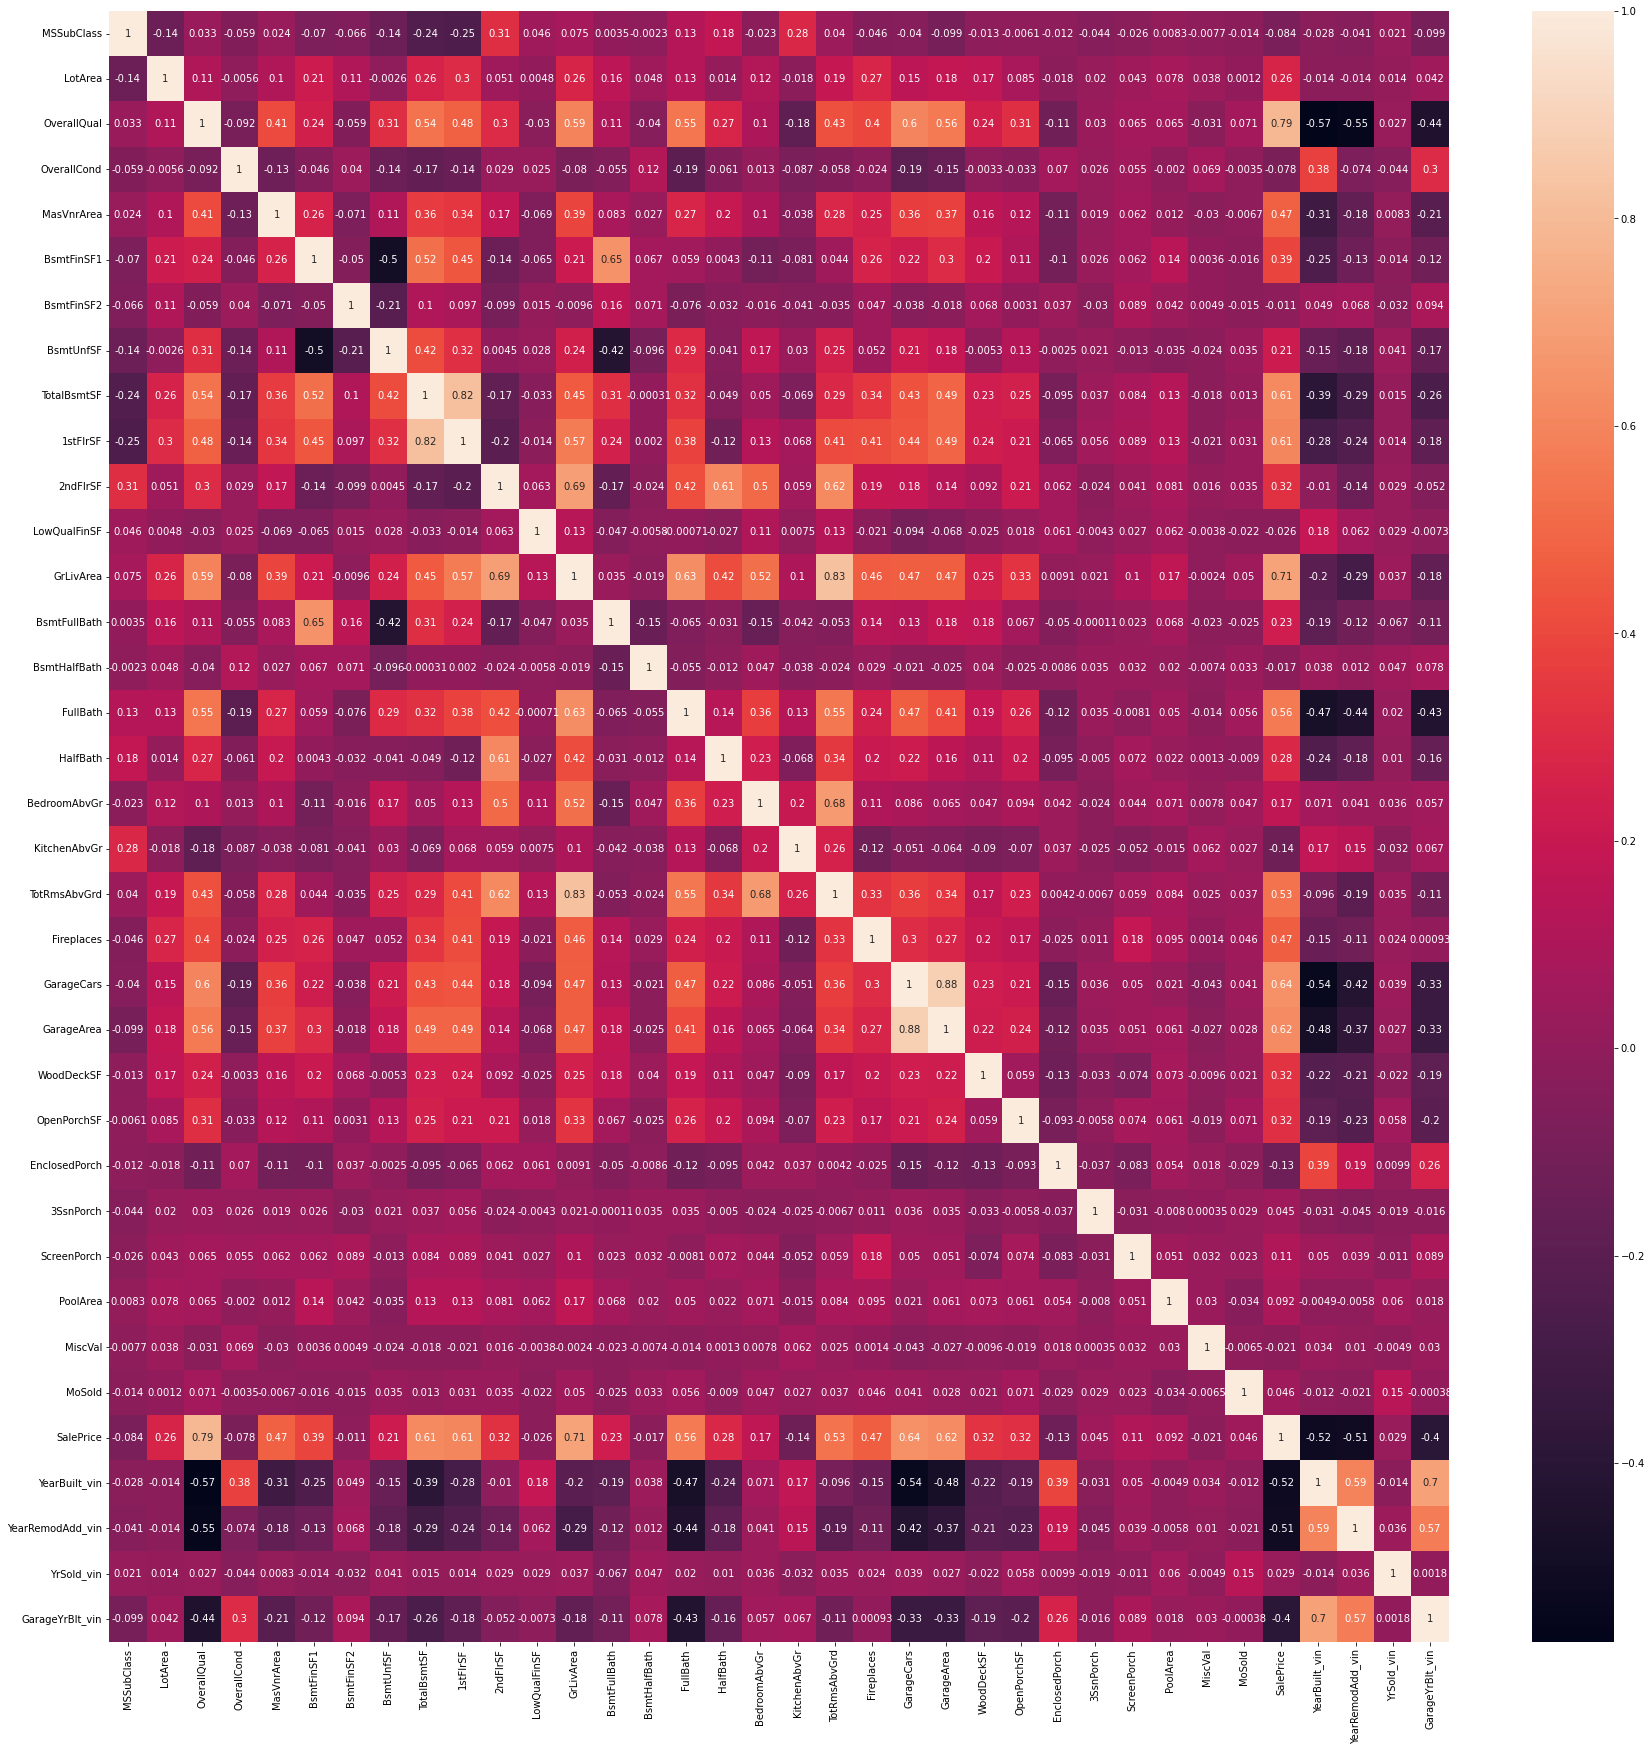

In [14]:
plt.figure(figsize=(30,30))
sns.heatmap(house_price.corr(), 
            xticklabels=house_price.corr().columns.values,
            yticklabels=house_price.corr().columns.values,annot= True)
plt.show()

In [15]:
# Finding the correlation coefficient and sorting and selecting values having coefficient greater than 0.5

corr_val = house_price[list(house_price.dtypes[house_price.dtypes != 'object'].index)].corr()
corr_coef = corr_val[corr_val['SalePrice'] > 0.5]['SalePrice'].sort_values(ascending=False)
print(corr_coef[1:])
corr_coef_cols = [idx for idx in corr_coef.index]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64


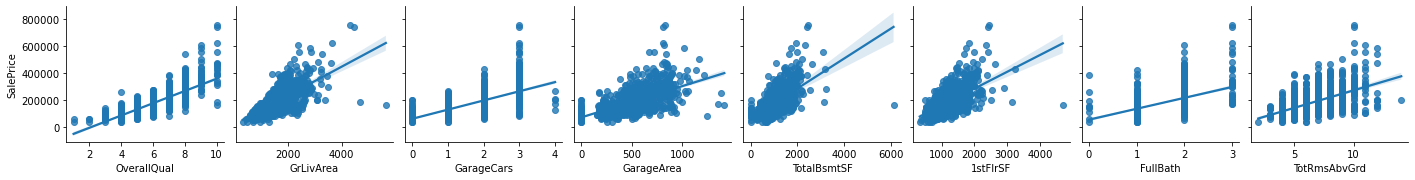

In [16]:
# Draw Pair plot for the correlated features
sns.pairplot(house_price, x_vars=corr_coef_cols[1:], y_vars=[corr_coef_cols[0]], kind="reg" )

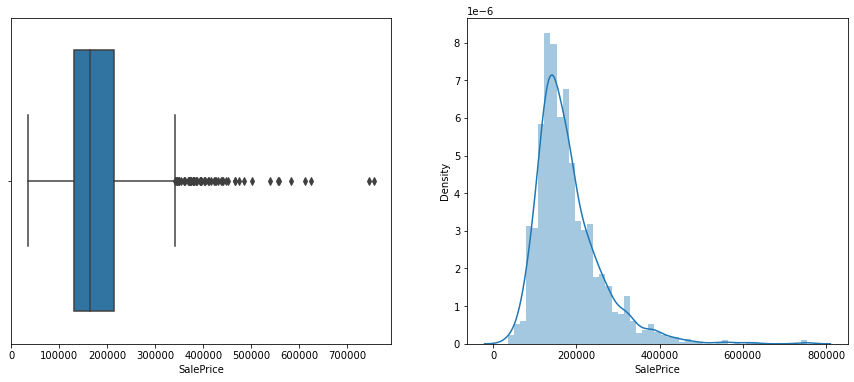

In [17]:
# Let us check the SalePrice as well
f, axes = plt.subplots(1, 2, figsize=(15,6))
sns.boxplot(house_price['SalePrice'],  orient='v' , ax=axes[0])
sns.distplot(house_price['SalePrice'], ax=axes[1])
plt.show()

## Feature engineering  
## Label encoding

In [18]:
house_price[list(house_price.dtypes[house_price.dtypes=='object'].index)].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


Checking for the below columns here we can clearly see that these are having some kind of order and hence we can say these are ordinal in nature

In [19]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1


In [20]:
house_price['LandSlope'] = house_price.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
house_price['Street'] = house_price.Street.map({'Grvl':0,'Pave':1})
house_price['Utilities'] = house_price.Utilities.map({'AllPub':0,'NoSewr':1,'NoSeWa':2,'ELO':3})
house_price['ExterQual'] = house_price.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['BsmtQual'] = house_price.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtCond'] = house_price.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtExposure'] = house_price.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
house_price['BsmtFinType1'] = house_price.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['BsmtFinType2'] = house_price.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['HeatingQC'] = house_price.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['CentralAir'] = house_price.CentralAir.map({'N':0,'Y':1})
house_price['KitchenQual'] = house_price.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['GarageFinish'] = house_price.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
house_price['GarageQual'] = house_price.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['GarageCond'] = house_price.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['ExterCond'] = house_price.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['LotShape'] = house_price.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

Taking look at converted columns

In [21]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


Creating and joining dummy variables with actual Data set




In [22]:
dummy_col = pd.get_dummies(house_price[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],
                           drop_first=True)

house_price = pd.concat([house_price,dummy_col],axis='columns')

house_price = house_price.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

In [23]:
# Target variable transformation
# Transform SalePrice
house_price['SalePrice'] = np.log1p(house_price['SalePrice'])

## Model Building 

In [24]:
# Create train and test data
df_train, df_test = train_test_split(house_price, train_size=0.7, test_size=0.3, random_state=100)

#### Scaling the train dataset.


Note as scale of our dependent valriable SalePrice is very different with the independent variable i am scaling the dependent variable


In [25]:
# scaling Data
num_col = ['MSSubClass','LotArea','OverallQual','OverallCond',
           'MasVnrArea','BsmtFinSF1',
           'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
           'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
           'ScreenPorch','PoolArea','MiscVal','SalePrice']

scaler = StandardScaler()
df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_test[num_col] = scaler.transform(df_test[num_col])

In [26]:
df_train.head()

,MSSubClass,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,-0.657071,-0.473765,1,3,0,0,-0.779861,0.383154,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0
318,0.035976,-0.056845,1,3,0,1,0.649651,-0.533005,0.809137,3,...,0,0,0,0,1,0,0,0,1,0
239,-0.195040,-0.169324,1,3,0,0,-0.065105,-1.449164,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0
986,-0.195040,-0.502297,1,3,0,0,-0.065105,2.215472,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0
1416,3.039179,0.082905,1,3,0,0,-1.494617,0.383154,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

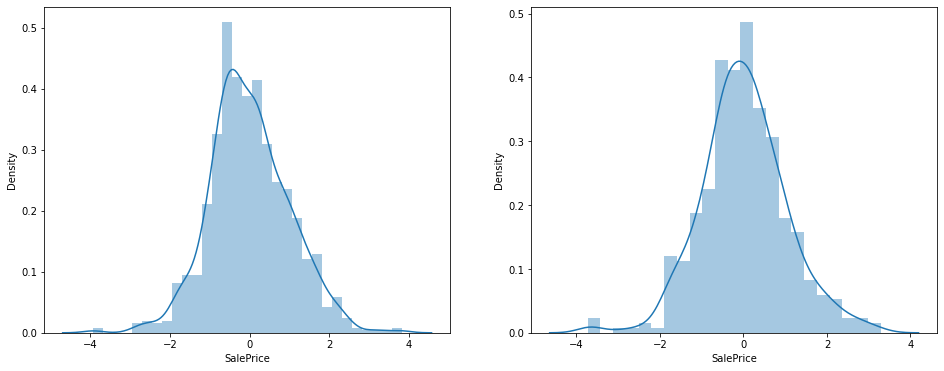

In [27]:
# Let us check if the target variable is normal in both train and test dataset
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(df_train.SalePrice)
plt.subplot(122)
sns.distplot(df_test.SalePrice)

In [28]:
# Create X and y
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

Now using RFE lets try to to find the optimal number of feature
Note : we cannot use RFE with GridSearchCV as 192 variable with 5 folds will create 960 fit and it will take more than 1 Hour to get the result so i am using RFE directly

In [29]:
house_price.head()

,MSSubClass,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,1,3,0,0,7,5,196.0,3,...,0,0,0,0,1,0,0,0,1,0
1,20,9600,1,3,0,0,6,8,0.0,2,...,0,0,0,0,1,0,0,0,1,0
2,60,11250,1,0,0,0,7,5,162.0,3,...,0,0,0,0,1,0,0,0,1,0
3,70,9550,1,0,0,0,7,5,0.0,2,...,0,0,0,0,1,0,0,0,0,0
4,60,14260,1,0,0,0,8,5,350.0,3,...,0,0,0,0,1,0,0,0,1,0


In [30]:
X_train.head()

,MSSubClass,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,-0.657071,-0.473765,1,3,0,0,-0.779861,0.383154,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0
318,0.035976,-0.056845,1,3,0,1,0.649651,-0.533005,0.809137,3,...,0,0,0,0,1,0,0,0,1,0
239,-0.195040,-0.169324,1,3,0,0,-0.065105,-1.449164,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0
986,-0.195040,-0.502297,1,3,0,0,-0.065105,2.215472,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0
1416,3.039179,0.082905,1,3,0,0,-1.494617,0.383154,-0.558025,2,...,0,0,0,0,1,0,0,0,1,0


In [31]:
# RFE
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,50)
rfe.fit(X_train,y_train)






RFE(estimator=LinearRegression(), n_features_to_select=50)

In [32]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
col = X_train.columns[rfe.support_]

In [33]:
# Modify the X_train and X_test
X_train = X_train[col]
X_test = X_test[col]

In [34]:
X_train.shape

(1021, 50)

In [35]:
X_test.shape

(438, 50)

## Lasso Regression Model

In [36]:
#Lasso
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

# train score
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train,y_pred=y_train_pred))

# test score
y_test_pred  = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test,y_pred=y_test_pred))

0.8824531653520857
0.8674841255256345


In [37]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = X_train.columns
col = col.insert(0,'Constant')
list(zip(col,model_parameter))

[('Constant', -1.927),
 ('OverallQual', 0.288),
 ('OverallCond', 0.119),
 ('BsmtQual', 0.163),
 ('BsmtFinSF1', 0.082),
 ('TotalBsmtSF', 0.028),
 ('CentralAir', 0.289),
 ('1stFlrSF', 0.306),
 ('2ndFlrSF', 0.248),
 ('GarageCars', 0.141),
 ('MSZoning_FV', 0.402),
 ('MSZoning_RH', 0.249),
 ('MSZoning_RL', 0.393),
 ('MSZoning_RM', 0.006),
 ('Neighborhood_ClearCr', 0.44),
 ('Neighborhood_Edwards', -0.233),
 ('Neighborhood_MeadowV', -0.169),
 ('Condition1_Norm', 0.184),
 ('Condition1_PosA', 0.205),
 ('Condition1_PosN', 0.065),
 ('Condition1_RRAe', -0.0),
 ('Condition2_PosN', -2.567),
 ('Condition2_RRAn', -0.0),
 ('Condition2_RRNn', 0.0),
 ('HouseStyle_2.5Fin', -0.0),
 ('RoofMatl_CompShg', 0.363),
 ('RoofMatl_Membran', 0.0),
 ('RoofMatl_Metal', 0.0),
 ('RoofMatl_Roll', 0.0),
 ('RoofMatl_Tar&Grv', 0.103),
 ('RoofMatl_WdShake', 0.0),
 ('RoofMatl_WdShngl', 0.474),
 ('Exterior1st_AsphShn', -0.0),
 ('Exterior1st_BrkComm', -0.0),
 ('Exterior1st_CBlock', -0.0),
 ('Exterior1st_VinylSd', 0.119),
 ('Ext

### use of grid search

In [38]:
# Gridsearch Operation on Training data set
# Objective - Find optimal value of alpha

folds = KFold(n_splits=10,shuffle=True,random_state=100)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [39]:
cv_result_train_lasso = pd.DataFrame(model_cv.cv_results_)
cv_result_train_lasso['param_alpha'] = cv_result_train_lasso['param_alpha'].astype('float32')
cv_result_train_lasso.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.012639,0.004484,0.003043,0.003526,0.001,{'alpha': 0.001},0.889046,0.472515,0.886084,0.726022,...,0.883320,0.883657,0.876965,0.879191,0.880469,0.881324,0.881314,0.887844,0.884983,0.010471
1,0.004968,0.003893,0.002704,0.003751,0.010,{'alpha': 0.01},0.868418,0.528608,0.877976,0.737188,...,0.848874,0.857834,0.843549,0.847401,0.847780,0.844370,0.846927,0.851757,0.851446,0.009576
2,0.004975,0.004597,0.002291,0.002894,0.100,{'alpha': 0.1},0.785805,0.592185,0.789836,0.681200,...,0.760875,0.776640,0.753118,0.760965,0.764499,0.755711,0.759480,0.760101,0.764102,0.011612
3,0.004060,0.003587,0.001175,0.002588,1.000,{'alpha': 1.0},-0.015358,-0.033031,-0.002682,-0.002716,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.006322,0.003694,0.000193,0.000578,5.000,{'alpha': 5.0},-0.015358,-0.033031,-0.002682,-0.002716,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


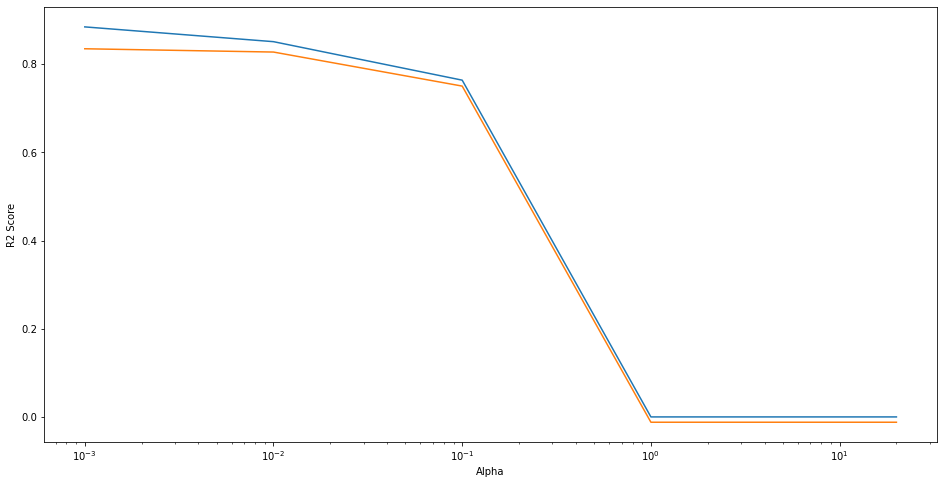

In [40]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_train_lasso['param_alpha'],cv_result_train_lasso['mean_train_score'])
plt.plot(cv_result_train_lasso['param_alpha'],cv_result_train_lasso['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [41]:
print('For Lasso, the Best Alpha value = ', model_cv.best_params_['alpha'])

For Lasso, the Best Alpha value =  0.001


## Running the model with best alpha

In [42]:
# Now that we have optimal value of alpha = 0.001, we can use this alpha to run the model again
#Lasso
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

# train score
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train,y_pred=y_train_pred))

# test score
y_test_pred  = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test,y_pred=y_test_pred))

0.8824531653520857
0.8674841255256345


In [57]:
# Now that we have  value of alpha = 0.002,that is double of brst alpha  we can use this alpha to run the model again
#Lasso
lm = Lasso(alpha=0.002)
lm.fit(X_train,y_train)

# train score
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train,y_pred=y_train_pred))

# test score
y_test_pred  = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test,y_pred=y_test_pred))

0.8724978734266955
0.8753900861605692


Lasso Test result has r2 of .87 which is quite good.

# Ridge regression model

In [43]:
#Ridge
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

# train score
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_train, y_train_pred))

# test score
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_test, y_test_pred))

0.9254384562320285
0.852384813867741


As we can see the above alpha value is not optimal for ridge there are sign of overfitting the clear difference we can see in the train and test score
Now lets try to improve our model with the optimal value of alpha using GridSearchCV

In [44]:
# Gridsearch Operation on Training data set
# Objective - Find optimal value of alpha

folds = KFold(n_splits=10,shuffle=True,random_state=100)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [45]:
cv_result_train_ridge = pd.DataFrame(model_cv.cv_results_)
cv_result_train_ridge['param_alpha'] = cv_result_train_ridge['param_alpha'].astype('float32')
cv_result_train_ridge.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.006950,0.004624,0.005017,0.005052,0.001,{'alpha': 0.001},0.908697,0.437990,0.890290,0.642283,...,0.927974,0.926755,0.921652,0.926145,0.924603,0.924551,0.925139,0.930926,0.925886,0.002312
1,0.006956,0.004492,0.001693,0.002692,0.010,{'alpha': 0.01},0.908347,0.439180,0.890892,0.649624,...,0.927620,0.926417,0.921373,0.925786,0.924320,0.924286,0.924784,0.930574,0.925591,0.002278
2,0.005204,0.004257,0.004561,0.003724,0.100,{'alpha': 0.1},0.904422,0.449622,0.890665,0.682481,...,0.917616,0.916871,0.912483,0.915608,0.915272,0.915697,0.914820,0.920666,0.916925,0.003259
3,0.002686,0.003419,0.001971,0.003342,1.000,{'alpha': 1.0},0.894047,0.492729,0.886256,0.712407,...,0.890329,0.893646,0.884344,0.887245,0.886847,0.887803,0.887960,0.893691,0.891673,0.008882
4,0.004535,0.004245,0.002585,0.003882,5.000,{'alpha': 5.0},0.884762,0.516813,0.884514,0.726134,...,0.873982,0.882710,0.867724,0.870525,0.870831,0.870858,0.871907,0.877147,0.876135,0.009967


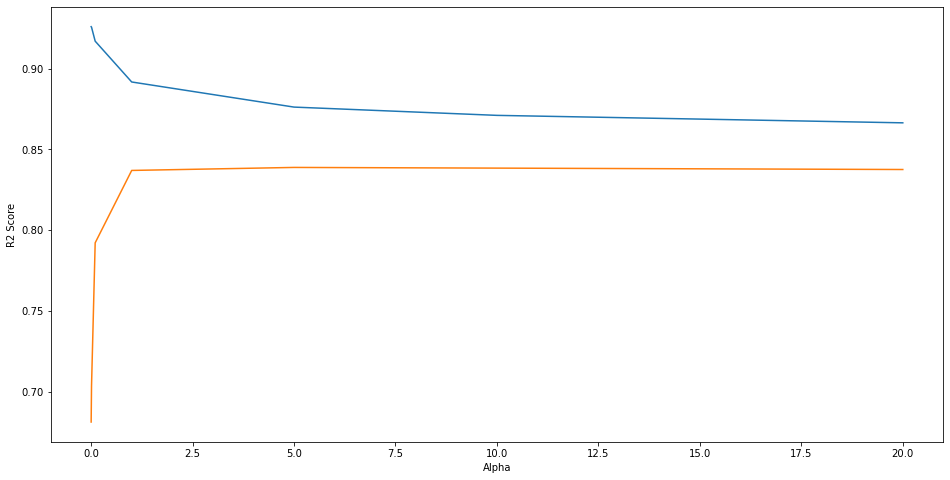

In [46]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_train_ridge['param_alpha'],cv_result_train_ridge['mean_train_score'])
plt.plot(cv_result_train_ridge['param_alpha'],cv_result_train_ridge['mean_test_score'])
plt.xlabel('Alpha')
# plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [47]:
print('For Ridge, the Best Alpha value = ', model_cv.best_params_['alpha'])

For Ridge, the Best Alpha value =  5.0


In [48]:
# Now that we have optimal value of alpha = 5, we can use this alpha to run the model again
#Ridge
ridge = Ridge(alpha=5)
ridge.fit(X_train,y_train)

# train score
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_train, y_train_pred))

# test score
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_test, y_test_pred))

0.8751481180098551
0.8794928016354047


In [49]:
# Now that we have  value of alpha = 10 that is double of optimal for assignment , we can use this alpha to run the model again
#Ridge
ridge = Ridge(alpha=10)
ridge.fit(X_train,y_train)

# train score
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_train, y_train_pred))

# test score
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_test, y_test_pred))

0.8701136496944915
0.8792596139731554


In [50]:
# ridge coefficients
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = X_train.columns
col = col.insert(0,'Constant')
list(zip(col,model_parameter))

[('Constant', -1.596),
 ('OverallQual', 0.292),
 ('OverallCond', 0.119),
 ('BsmtQual', 0.165),
 ('BsmtFinSF1', 0.076),
 ('TotalBsmtSF', 0.035),
 ('CentralAir', 0.267),
 ('1stFlrSF', 0.286),
 ('2ndFlrSF', 0.235),
 ('GarageCars', 0.148),
 ('MSZoning_FV', 0.24),
 ('MSZoning_RH', 0.113),
 ('MSZoning_RL', 0.265),
 ('MSZoning_RM', -0.115),
 ('Neighborhood_ClearCr', 0.3),
 ('Neighborhood_Edwards', -0.244),
 ('Neighborhood_MeadowV', -0.116),
 ('Condition1_Norm', 0.179),
 ('Condition1_PosA', 0.13),
 ('Condition1_PosN', -0.012),
 ('Condition1_RRAe', -0.048),
 ('Condition2_PosN', -0.303),
 ('Condition2_RRAn', -0.037),
 ('Condition2_RRNn', 0.037),
 ('HouseStyle_2.5Fin', -0.014),
 ('RoofMatl_CompShg', 0.167),
 ('RoofMatl_Membran', 0.042),
 ('RoofMatl_Metal', 0.036),
 ('RoofMatl_Roll', 0.002),
 ('RoofMatl_Tar&Grv', 0.06),
 ('RoofMatl_WdShake', 0.011),
 ('RoofMatl_WdShngl', 0.167),
 ('Exterior1st_AsphShn', -0.009),
 ('Exterior1st_BrkComm', -0.085),
 ('Exterior1st_CBlock', -0.027),
 ('Exterior1st_Viny

In [51]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feaure','Coef']

In [52]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
14,BsmtFinType1,0.300331
1,LotArea,0.291989
7,OverallCond,0.285979
6,OverallQual,0.267388
12,BsmtCond,0.265275
10,ExterCond,0.239674
8,MasVnrArea,0.235399
17,BsmtFinSF2,0.178572
25,GrLivArea,0.167188
31,KitchenAbvGr,0.166797


# Conclusion

- R2 score while using ridge is .88 while that in case of lasso is .87 .
- Here both R2 is comparable . however lasso penalizes more on dataset and more coefficent equal to zero so we will go agead with lasso model.

In [53]:
# Now that we have optimal value of alpha = 0.001, we can use this alpha to run the model again
#Lasso
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

# train score
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train,y_pred=y_train_pred))

# test score
y_test_pred  = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test,y_pred=y_test_pred))

0.8824531653520857
0.8674841255256345


In [54]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = X_train.columns
col = col.insert(0,'Constant')
#list(zip(col,model_parameter))
lasso_coef = pd.DataFrame(list(zip(cols,model_parameter)))
lasso_coef.columns = ['Feature','Coef']


In [55]:
# best 10 parameters that explains model as per lasso

lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
31,KitchenAbvGr,0.474
14,BsmtFinType1,0.440
10,ExterCond,0.402
12,BsmtCond,0.393
25,GrLivArea,0.363
7,OverallCond,0.306
6,OverallQual,0.289
1,LotArea,0.288
11,BsmtQual,0.249
8,MasVnrArea,0.248


In [56]:
# best 10 parameters that explains model as per ridge

ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
14,BsmtFinType1,0.300331
1,LotArea,0.291989
7,OverallCond,0.285979
6,OverallQual,0.267388
12,BsmtCond,0.265275
10,ExterCond,0.239674
8,MasVnrArea,0.235399
17,BsmtFinSF2,0.178572
25,GrLivArea,0.167188
31,KitchenAbvGr,0.166797


- After compairing both the model we can see that the below Features are best explaining the DataSet

    - BsmtFinType1
    - ExterCond
    - KitchenAbvGr	
    - BsmtCond
    - OverallCond
    - GrLivArea
    - OverallQual
    - LotArea	
    - MasVnrArea

- Best alpha value for Lasso : {'alpha': 0.001}
- Best alpha value for Ridge : {'alpha':5}